# 爬取Facebook粉絲專頁資料 第一篇 - 獲取粉絲專頁的資料(post)

### 透過Facebook Graph API去抓取粉絲專頁的資料，但是使用Facebook Graph API需要token(權杖)
### 我們透過建立Facebook App的應用程式，並使用該應用程式的帳號(APP ID)和密碼(APP Secret)當作權限

[[說明]Graph API是什麼東東？](http://www.tonylin.idv.tw/dokuwiki/doku.php/facebook:basic:graphapi)

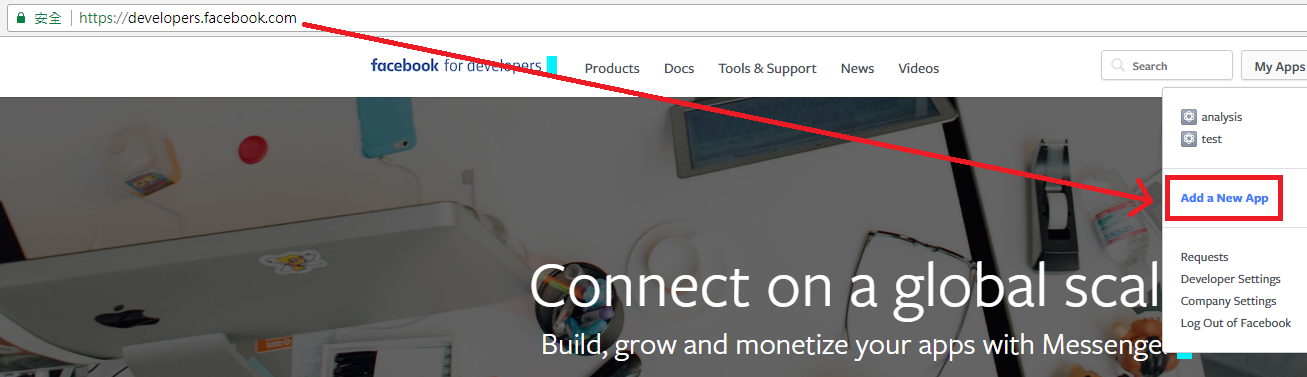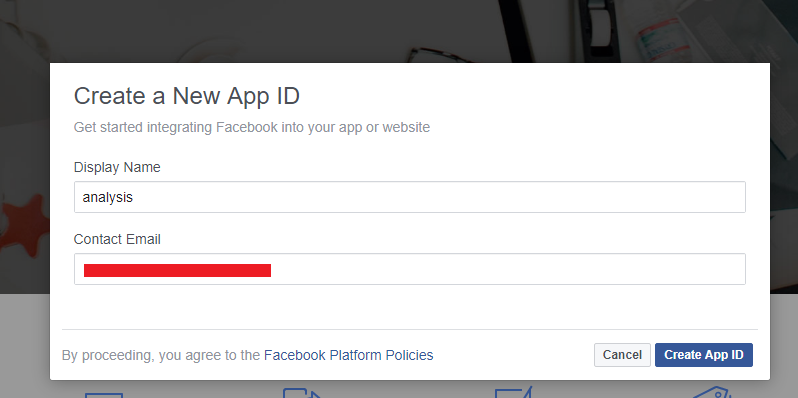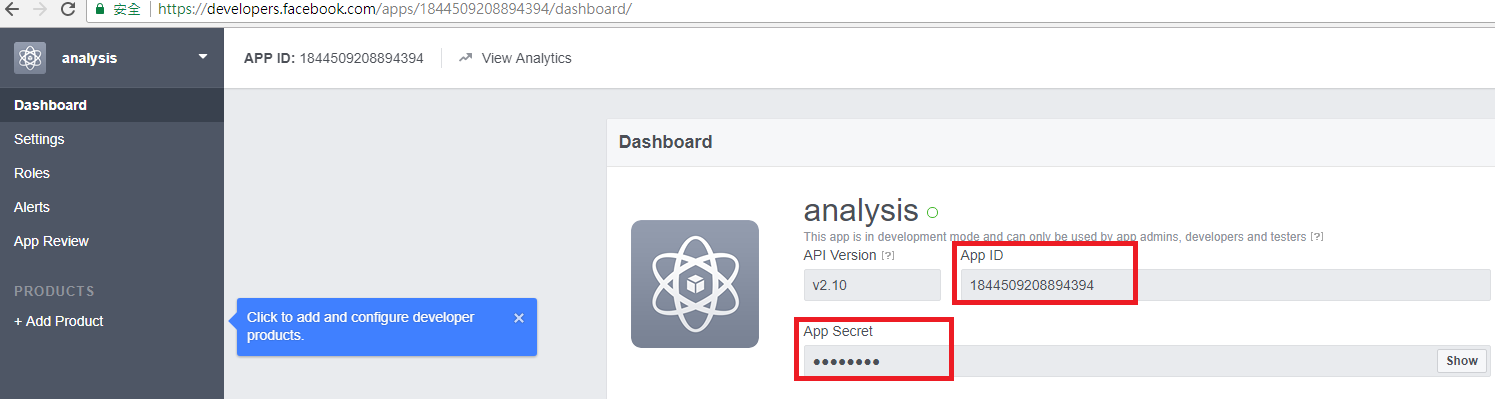

In [ ]:
#載入函式庫
import json
import datetime
import csv
import time
try:
    from urllib.request import urlopen, Request
except ImportError:
    from urllib2 import urlopen, Request

## 使用上面取得的APP ID和App Secret作為權杖（token）

In [ ]:
app_id = ""
app_secret = ""  # DO NOT SHARE WITH ANYONE!

access_token = app_id + "|" + app_secret

## 獲取粉絲專頁的ID

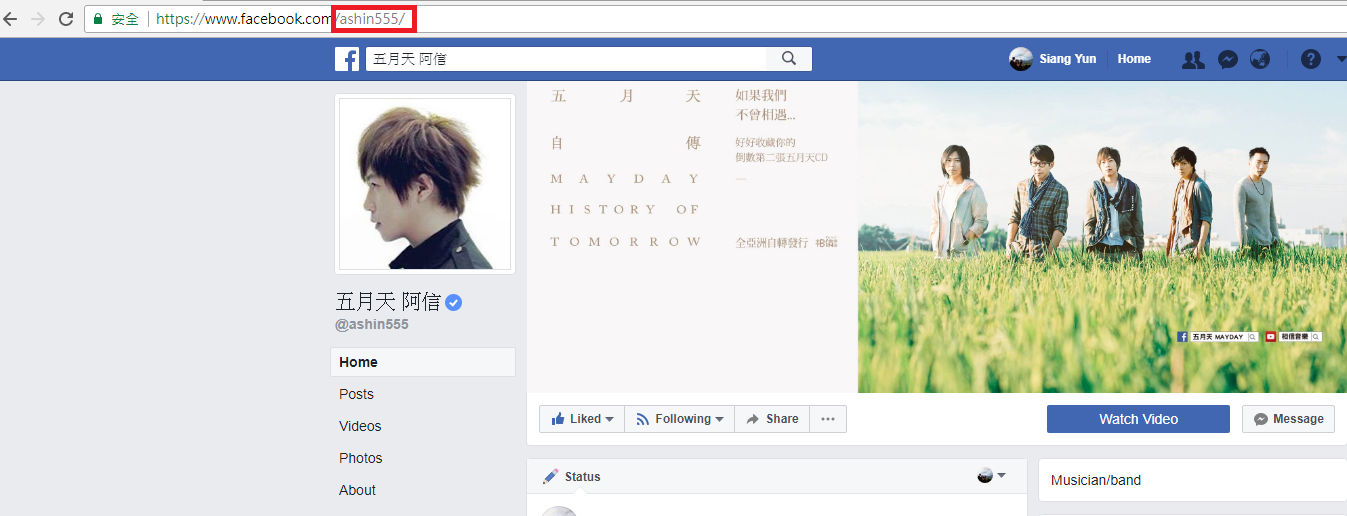

## 因為要分析的粉絲專頁不止一個，所以把要分析的粉絲專頁的ID以list的形態存進page_id

In [ ]:
page_id = ["appledaily.tw","tsaiingwen","MaYingjeou","starbuckstaiwan","duncanlindesign","jay","ashin555","YahooTWNews","ETtoday","news.ebc"]

## 可設定爬取資料的日期
## 如果沒輸入則是從粉絲專頁最開始的日期爬至目前的日期

In [ ]:
#開始的日期
since_date = "" 

#結束的日期
until_date = ""

## 程式主要由6個函式組成

request_until_succeed(url)
確保爬取資料直到成功
    
unicode_decode(text)
將抓取的文字decode再儲存
    
getFacebookPageFeedUrl(base_url)
定義要從粉絲專頁取得的欄位
    
getReactionsForStatuses(base_url):
取得貼文（Post）的反應數（like,love...)
    
processFacebookPageFeedStatus(status)
取得粉絲專頁的資料並且結構化

scrapeFacebookPageFeedStatus(page_id, access_token, since_date, until_date)
為主程式，裡面會呼叫其他function來完成爬蟲動作

## 爬取資料的基本概念是由使用者發送request透過Facebook Graph API來取得資料
### 但是爬取資料量太大的粉絲專頁的時候，很有可能發送的request太多了而發生錯誤
### 因此使用了While迴圈，發生錯誤就休息5秒，5秒後再重新發送request


In [ ]:
def request_until_succeed(url):
    req = Request(url)
    success = False
    while success is False:
        try:
            response = urlopen(req)
            if response.getcode() == 200:
                success = True
        except Exception as e:
            print(e)
            time.sleep(5)

            print("Error for URL {}: {}".format(url, datetime.datetime.now()))
            print("Retrying.")

    return response.read().decode('utf8')

## 取得的文字如果不經過處理會以亂碼儲存，所以要經過encode和decode之後轉成正常的文字

In [ ]:
# Needed to write tricky unicode correctly to csv
def unicode_decode(text):
    try:
        return text.encode('utf-8').decode()
    except UnicodeDecodeError:
        return text.encode('utf-8')

## fields是要取得的資料的種類

In [ ]:
def getFacebookPageFeedUrl(base_url):

    fields = "&fields=message,link,created_time,type,name,id," + \
        "comments.limit(0).summary(true),shares,reactions" + \
        ".limit(0).summary(true)"

    return base_url + fields

## 取得貼文的反應數量(angry,like,love,sad,wow,haha個別的數量)

In [ ]:
def getReactionsForStatuses(base_url):

    reaction_types = ['like', 'love', 'wow', 'haha', 'sad', 'angry']
    reactions_dict = {}
    
    for reaction_type in reaction_types:
        fields = "&fields=reactions.type({}).limit(0).summary(total_count)".format(
            reaction_type.upper())

        url = base_url + fields

        data = json.loads(request_until_succeed(url))['data']

        data_processed = set()
        for status in data:
            id = status['id']
            count = status['reactions']['summary']['total_count']
            data_processed.add((id, count))

        for id, count in data_processed:
            if id in reactions_dict:
                reactions_dict[id] = reactions_dict[id] + (count,)
            else:
                reactions_dict[id] = (count,)

    return reactions_dict


## 處理取得資料並將資料結構化

In [ ]:
def processFacebookPageFeedStatus(status):

    status_id = status['id']
    status_type = status['type']

    status_message = '' if 'message' not in status else \
        unicode_decode(status['message'])
    link_name = '' if 'name' not in status else \
        unicode_decode(status['name'])
    status_link = '' if 'link' not in status else \
        unicode_decode(status['link'])

    status_published = datetime.datetime.strptime(
        status['created_time'], '%Y-%m-%dT%H:%M:%S+0000')
    status_published = status_published + \
        datetime.timedelta(hours=8)  # 台灣的時區 +8
    status_published = status_published.strftime(
        '%Y-%m-%d %H:%M:%S')

    num_reactions = 0 if 'reactions' not in status else \
        status['reactions']['summary']['total_count']
    num_comments = 0 if 'comments' not in status else \
        status['comments']['summary']['total_count']
    num_shares = 0 if 'shares' not in status else status['shares']['count']

    return (status_id, status_message, link_name, status_type, status_link,
            status_published, num_reactions, num_comments, num_shares)


## 將取得的資料寫入csv檔
## base : 設定facebook API的版本，我們使用的是2.9
## node : 要分析哪一個粉絲專頁
## parameters : 權限設定和每次取多少筆
## since : 從什麼日期開始爬取資料
## until : 爬取資料至什麼日期

In [ ]:
def scrapeFacebookPageFeedStatus(page_id, access_token, since_date, until_date):
    with open('{}_facebook_statuses.csv'.format(page_id), 'w' ,encoding='utf-8-sig') as file:
        w = csv.writer(file)
        w.writerow(["status_id", "status_message", "link_name", "status_type",
                    "status_link", "status_published", "num_reactions",
                    "num_comments", "num_shares", "num_likes", "num_loves",
                    "num_wows", "num_hahas", "num_sads", "num_angrys",
                    "num_special"])
        has_next_page = True
        num_processed = 0
        scrape_starttime = datetime.datetime.now()
        after = ''
        base = "https://graph.facebook.com/v2.9"
        node = "/{}/posts".format(page_id)
        parameters = "/?limit={}&access_token={}".format(100, access_token)
        since = "&since={}".format(since_date) if since_date \
            is not '' else ''
        until = "&until={}".format(until_date) if until_date \
            is not '' else ''

        print("Scraping {} Facebook Page: {}\n".format(page_id, scrape_starttime))

        while has_next_page:
            after = '' if after is '' else "&after={}".format(after)
            base_url = base + node + parameters + after + since + until

            url = getFacebookPageFeedUrl(base_url)
            statuses = json.loads(request_until_succeed(url))
            reactions = getReactionsForStatuses(base_url)

            for status in statuses['data']:

                if 'reactions' in status:
                    status_data = processFacebookPageFeedStatus(status)
                    reactions_data = reactions[status_data[0]]

                    num_special = status_data[6] - sum(reactions_data)
                    w.writerow(status_data + reactions_data + (num_special,))

                #每100篇就輸出目前抓了多少篇貼文及時間
                num_processed += 1
                if num_processed % 100 == 0:
                    print("{} Statuses Processed: {}".format
                          (num_processed, datetime.datetime.now()))

            if 'paging' in statuses:
                after = statuses['paging']['cursors']['after']
            else:
                has_next_page = False

        print("\nDone!\n{} Statuses Processed in {}".format(
              num_processed, datetime.datetime.now() - scrape_starttime))


## 呼叫主程式，跑迴圈來分別對粉絲專頁進行爬蟲的動作

In [ ]:
if __name__ == '__main__':
    for filename in page_id:
        scrapeFacebookPageFeedStatus(filename, access_token, since_date, until_date)